In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw7.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 7: Word embeddings and topic modeling 
**Due date: See the [Calendar](https://htmlpreview.github.io/?https://github.com/UBC-CS/cpsc330/blob/master/docs/calendar.html).**

## Imports

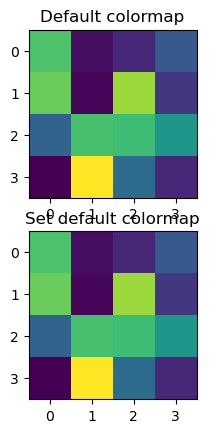

In [2]:
import os
import re
import string
import sys
import time


sys.path.append(os.path.join(os.path.abspath("../../lectures/"), "code"))

%matplotlib inline
import matplotlib.pyplot as plt
from plotting_functions_unsup import *

import IPython
import numpy as np
import numpy.random as npr
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from comat import CooccurrenceMatrix
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from preprocessing import MyPreprocessor

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

<br><br>

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
## Submission instructions
<hr>
rubric={points}

**Please be aware that this homework assignment requires installation of several packages in your course environment. It's possible that you'll encounter installation challenges, which might be frustrating. However, remember that solving these issues is not wasting time but it is an essential skill for anyone aspiring to work in data science or machine learning.**

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2023W1/blob/main/docs/homework_instructions.md). 

**You may work in a group on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 4. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).


When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission.
4. Make sure that the plots and output are rendered properly in your submitted file. 
5. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb. If the pdf or html also fail to render on Gradescope, please create two files for your homework: hw6a.ipynb with Exercise 1 and hw6b.ipynb with Exercises 2 and 3 and submit these two files in your submission.  
</div>

_Points:_ 2

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 1:  Exploring pre-trained word embeddings <a name="1"></a>
<hr>

In lecture 17, we talked about natural language processing (NLP). Using pre-trained word embeddings is very common in NLP. It has been shown that pre-trained word embeddings work well on a variety of text classification tasks. These embeddings are created by training a model like Word2Vec on a huge corpus of text such as a dump of Wikipedia or a dump of the web crawl. 

A number of pre-trained word embeddings are available out there. Some popular ones are: 

- [GloVe](https://nlp.stanford.edu/projects/glove/)
    * trained using [the GloVe algorithm](https://nlp.stanford.edu/pubs/glove.pdf) 
    * published by Stanford University 
- [fastText pre-trained embeddings for 294 languages](https://fasttext.cc/docs/en/pretrained-vectors.html) 
    * trained using the fastText algorithm
    * published by Facebook
    
In this exercise, you will be exploring GloVe Wikipedia pre-trained embeddings. The code below loads the word vectors trained on Wikipedia using an algorithm called Glove. You'll need `gensim` package in your cpsc330 conda environment to run the code below. 

```
> conda activate cpsc330
> conda install -c anaconda gensim
```

In [3]:
import gensim
import gensim.downloader

print(list(gensim.downloader.info()["models"].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [4]:
# This will take a while to run when you run it for the first time.
import gensim.downloader as api

glove_wiki_vectors = api.load("glove-wiki-gigaword-100")

In [5]:
len(glove_wiki_vectors)

400000

There are 400,000 word vectors in this pre-trained model. 

Now that we have GloVe Wiki vectors loaded in `glove_wiki_vectors`, let's explore the embeddings. 

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 Word similarity using pre-trained embeddings
rubric={points}

**Your tasks:**

- Come up with a list of 4 words of your choice and find similar words to these words using `glove_wiki_vectors` embeddings.

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 2

In [6]:
words = ["coffee", "kick", "subway", "software"]

In [7]:
result = {}
for word in words:
    similar = glove_wiki_vectors.most_similar(word)
    result[word] = similar
pd.DataFrame(result).T

,0,1,2,3,4,5,6,7,8,9
coffee,"(tea, 0.77326899766922)","(drinks, 0.7287518978118896)","(beer, 0.7253385186195374)","(cocoa, 0.7026591300964355)","(wine, 0.7002726793289185)","(drink, 0.6990923881530762)","(corn, 0.6825440526008606)","(sugar, 0.6775094270706177)","(bread, 0.6727856993675232)","(fruit, 0.667149007320404)"
kick,"(kicks, 0.7849088907241821)","(ball, 0.7723649740219116)","(kicked, 0.76600581407547)","(minute, 0.7423369288444519)","(goal, 0.7406333088874817)","(header, 0.709308922290802)","(deflected, 0.7035992741584778)","(pass, 0.7008392810821533)","(missed, 0.6999455094337463)","(equalizer, 0.6820622682571411)"
subway,"(subways, 0.7338516712188721)","(train, 0.7133814096450806)","(rail, 0.6966160535812378)","(bus, 0.6924630999565125)","(metro, 0.6873050332069397)","(trains, 0.6864566802978516)","(commuter, 0.6844821572303772)","(tram, 0.6830512881278992)","(transit, 0.652100145816803)","(tunnel, 0.6475099921226501)"
software,"(computer, 0.8373122215270996)","(hardware, 0.7876607775688171)","(microsoft, 0.7803657650947571)","(applications, 0.7419033646583557)","(technology, 0.7358859777450562)","(server, 0.7342713475227356)","(user, 0.7320204973220825)","(computers, 0.7276959419250488)","(desktop, 0.7261441349983215)","(web, 0.7209519147872925)"


In [8]:
...

Ellipsis

In [9]:
...

Ellipsis

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 Word similarity using pre-trained embeddings
rubric={points}

**Your tasks:**

1. Calculate cosine similarity for the following word pairs (`word_pairs`) using the [`similarity`](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=similarity#gensim.models.keyedvectors.KeyedVectors.similarity) method of `glove_wiki_vectors`.

In [10]:
word_pairs = [
    ("coast", "shore"),
    ("clothes", "closet"),
    ("old", "new"),
    ("smart", "intelligent"),
    ("dog", "cat"),
    ("tree", "lawyer"),
]

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 2

In [11]:
for pair in word_pairs:
    print(
        "The similarity between %s and %s is %0.3f"
        % (pair[0], pair[1], glove_wiki_vectors.similarity(pair[0], pair[1]))
    )

The similarity between coast and shore is 0.700
The similarity between clothes and closet is 0.546
The similarity between old and new is 0.643
The similarity between smart and intelligent is 0.755
The similarity between dog and cat is 0.880
The similarity between tree and lawyer is 0.077


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 Representation of all words in English
rubric={points}

**Your tasks:**

1. The vocabulary size of Wikipedia embeddings is quite large. The `test_words` list below contains a few new words (called neologisms) and biomedical domain-specific abbreviations. Write code to check whether `glove_wiki_vectors` have representation for these words or not. 
> If a given word `word` is in the vocabulary, `word in glove_wiki_vectors` will return True. 

In [12]:
test_words = [
    "covididiot",
    "fomo",
    "frenemies",
    "anthropause",
    "photobomb",
    "selfie",
    "pxg",  # Abbreviation for pseudoexfoliative glaucoma
    "pacg",  # Abbreviation for primary angle closure glaucoma
    "cct",  # Abbreviation for central corneal thickness
    "escc",  # Abbreviation for esophageal squamous cell carcinoma
]

<div class="alert alert-warning">

Solution_1_3
    
</div>

_Points:_ 2

In [13]:
test_result = {}
word_exists = []
words_not_exists = []
for word in test_words:
    if word in glove_wiki_vectors:
      test_result[word] = "True" 
      word_exists.append(word)
    else:
      test_result[word] = 'False'
      words_not_exists.append(word) 
test_result

{'covididiot': 'False',
 'fomo': 'False',
 'frenemies': 'True',
 'anthropause': 'False',
 'photobomb': 'False',
 'selfie': 'False',
 'pxg': 'False',
 'pacg': 'False',
 'cct': 'True',
 'escc': 'True'}

In [14]:
print(word_exists)

['frenemies', 'cct', 'escc']


In [15]:
print(words_not_exists)

['covididiot', 'fomo', 'anthropause', 'photobomb', 'selfie', 'pxg', 'pacg']


In [16]:
grader.check("q1.3")

/Users/celine/anaconda3/envs/cpsc330/lib/python3.10/site-packages/nbformat/__init__.py:93: MissingIDFieldWarning:

Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.



q1.3 results: All test cases passed!

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 Stereotypes and biases in embeddings
rubric={points}

Word vectors contain lots of useful information. But they also contain stereotypes and biases of the texts they were trained on. In the lecture, we saw an example of gender bias in Google News word embeddings. Here we are using pre-trained embeddings trained on Wikipedia data. 

**Your tasks:**

1. Explore whether there are any worrisome biases or stereotypes present in these embeddings by trying out at least 4 examples. You can use the following two methods or other methods of your choice to explore this. 
    - the `analogy` function below which gives word analogies (an example shown below)
    - [similarity](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=similarity#gensim.models.keyedvectors.KeyedVectors.similarity) or [distance](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=distance#gensim.models.keyedvectors.KeyedVectors.distances) methods (an example is shown below)

> Note that most of the recent embeddings are de-biased. But you might still observe some biases in them. Also, not all stereotypes present in pre-trained embeddings are necessarily bad. But you should be aware of them when you use them in your models. 

In [17]:
def analogy(word1, word2, word3, model=glove_wiki_vectors):
    """
    Returns analogy word using the given model.

    Parameters
    --------------
    word1 : (str)
        word1 in the analogy relation
    word2 : (str)
        word2 in the analogy relation
    word3 : (str)
        word3 in the analogy relation
    model :
        word embedding model

    Returns
    ---------------
        pd.dataframe
    """
    print("%s : %s :: %s : ?" % (word1, word2, word3))
    sim_words = model.most_similar(positive=[word3, word2], negative=[word1])
    return pd.DataFrame(sim_words, columns=["Analogy word", "Score"])

Examples of using analogy to explore biases and stereotypes.  

In [18]:
analogy("man", "doctor", "woman")

man : doctor :: woman : ?


,Analogy word,Score
0,nurse,0.773523
1,physician,0.718943
2,doctors,0.682433
3,patient,0.675068
4,dentist,0.672603
5,pregnant,0.664246
6,medical,0.652045
7,nursing,0.645348
8,mother,0.639333
9,hospital,0.638750


In [19]:
glove_wiki_vectors.similarity("aboriginal", "success")

0.14283244

In [20]:
glove_wiki_vectors.similarity("white", "success")

0.3518238

<div class="alert alert-warning">

Solution_1_4
    
</div>

_Points:_ 4

### gender biases

In [21]:
analogy("man", "manager", "woman")

man : manager :: woman : ?


,Analogy word,Score
0,assistant,0.656641
1,job,0.626392
2,supervisor,0.593479
3,owner,0.587832
4,hired,0.577390
5,consultant,0.570659
6,director,0.565653
7,office,0.564568
8,employee,0.561287
9,ceo,0.556422


In [22]:
glove_wiki_vectors.similarity("women", "manager")

0.13243

In [23]:
glove_wiki_vectors.similarity("man", "manager")

0.4557554

In [24]:
analogy("man", "boss", "woman")

man : boss :: woman : ?


,Analogy word,Score
0,bosses,0.649429
1,girlfriend,0.639793
2,boyfriend,0.623138
3,colleague,0.604826
4,lover,0.593473
5,husband,0.590123
6,ex,0.575455
7,friend,0.565926
8,wife,0.555912
9,housekeeper,0.527948


In [25]:
glove_wiki_vectors.similarity("women", "scientist")

0.14743488

In [26]:
glove_wiki_vectors.similarity("men", "scientist")

0.16145675

### Race biases

In [27]:
analogy("caucasian", "professor", "african-american")

caucasian : professor :: african-american : ?


,Analogy word,Score
0,lecturer,0.692862
1,associate,0.681594
2,harvard,0.666835
3,dean,0.653007
4,university,0.651051
5,emeritus,0.643217
6,yale,0.628395
7,faculty,0.626116
8,assistant,0.621903
9,sociology,0.617813


In [28]:
analogy("caucasian", "doctor", "african-american")

caucasian : doctor :: african-american : ?


,Analogy word,Score
0,physician,0.653751
1,dr.,0.620225
2,medical,0.615414
3,nurse,0.601160
4,psychologist,0.575256
5,assistant,0.572545
6,teacher,0.567794
7,psychiatrist,0.559851
8,author,0.559437
9,surgeon,0.553548


<!-- BEGIN QUESTION -->

### 1.5 Discussion
rubric={points}

**Your tasks:**
1. Discuss your observations from 1.4. Are there any worrisome biases in these embeddings trained on Wikipedia?   
2. Give an example of how using embeddings with biases could cause harm in the real world.

<div class="alert alert-warning">

Solution_1_5
    
</div>

_Points:_ 4

**1. Observations**
1. In the example provided, the "white" word is much closer to the word "success" than "aboriginal". 
2. There are also career-wide gender biases in the embeddings. In the analogy analysis, man to manager is mostly like women to "assistant".  What's worse, the analogy result also shows that man is to boss as woman is to girlfriend. Also, "man" has a much higher similarity score to "manager" than "woman" has, which is a fair representation of the real workforce where managers are dominated by males in most industries.
3. Another bias in the embedding is on race. When Caucasian is to professor, African-American is to lecturer. When Caucasian is to doctor, the most similar analogy is African-American to physicians. These results indicates that Caucasian is more associated to higher-paid and higher-level positions in the medical and academic professions than African-American.

**2.Impacts**

1. "white" is much closer to word "success" than "aboriginal", this biased representation can put aboriginal people in a disadvantaged position in their career development. If a company chooses to use an AI resume screening tool based on biased word embeddings, aboriginal or visual minority candidates may have a lower chance of getting selected for an interview than white candidates. 
2. Gender bias on professionals can enforce people's conception model, discouraging females from advancing their careers to the next level. 


<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: Topic modeling 

The goal of topic modeling is discovering high-level themes in a large collection of texts. 

In this homework, you will explore topics in [the 20 newsgroups text dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html) using `scikit-learn`'s `LatentDirichletAllocation` (LDA) model. 

Usually, topic modeling is used for discovering abstract "topics" that occur in a collection of documents when you do not know the actual topics present in the documents. But 20 newsgroups text dataset is labeled with categories (e.g., sports, hardware, religion), and you will be able to cross-check the topics discovered by your model with these available topics. 

The starter code below loads the train and test portion of the data and convert the train portion into a pandas DataFrame. For speed, we will only consider documents with the following 8 categories. 

In [29]:
from sklearn.datasets import fetch_20newsgroups

In [30]:
cats = [
    "rec.sport.hockey",
    "rec.sport.baseball",
    "soc.religion.christian",
    "alt.atheism",
    "comp.graphics",
    "comp.windows.x",
    "talk.politics.mideast",
    "talk.politics.guns",
]  # We'll only consider these categories out of 20 categories for speed.

newsgroups_train = fetch_20newsgroups(
    subset="train", remove=("headers", "footers", "quotes"), categories=cats
)
X_news_train, y_news_train = newsgroups_train.data, newsgroups_train.target
df = pd.DataFrame(X_news_train, columns=["text"])
df["target"] = y_news_train
df["target_name"] = [
    newsgroups_train.target_names[target] for target in newsgroups_train.target
]
df

,text,target,target_name
0,"You know, I was reading 18 U.S.C. 922 and some...",6,talk.politics.guns
1,\n\n\nIt's not a bad question: I don't have an...,1,comp.graphics
2,"\nActuallay I don't, but on the other hand I d...",1,comp.graphics
3,"The following problem is really bugging me,\na...",2,comp.windows.x
4,\n\n This is the latest from UPI \n\n For...,7,talk.politics.mideast
...,...,...,...
4558,Hi Everyone ::\n\nI am looking for some soft...,1,comp.graphics
4559,Archive-name: x-faq/part3\nLast-modified: 1993...,2,comp.windows.x
4560,"\nThat's nice, but it doesn't answer the quest...",6,talk.politics.guns
4561,"Hi,\n I just got myself a Gateway 4DX-33V ...",2,comp.windows.x


In [31]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.windows.x',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast']

<br><br>

<!-- BEGIN QUESTION -->

### 2.1 Preprocessing using [spaCy](https://spacy.io/)
rubric={points}

Preprocessing is a crucial step before carrying out topic modeling and it markedly affects topic modeling results. In this exercise, you'll prepare the data using [spaCy](https://spacy.io/) for topic modeling. 

**Your tasks:** 

- Write code using [spaCy](https://spacy.io/) to preprocess the `text` column in the given dataframe `df` and save the processed text in a new column called `text_pp` within the same dataframe.

If you do not have spaCy in your course environment, you'll have to [install it](https://spacy.io/usage) and download the pretrained model en_core_web_md. 

`python -m spacy download en_core_web_md`


Note that there is no such thing as "perfect" preprocessing. You'll have to make your own judgments and decisions on which tokens are likely to be more informative for the given task. Some common text preprocessing steps for topic modeling include: 
- getting rid of slashes, new-line characters, or any other non-informative characters
- sentence segmentation and tokenization      
- replacing urls, email addresses, or numbers with generic tokens such as "URL",  "EMAIL", "NUM". 
- getting rid of other fairly unique tokens which are not going to help us in topic modeling  
- excluding stopwords and punctuation 
- lemmatization


> Check out [these available attributes](https://spacy.io/api/token#attributes) for `token` in spaCy which might help you with preprocessing. 

> You can also get rid of words with specific POS tags. [Here](https://universaldependencies.org/u/pos/) is the list of part-of-speech tags used in spaCy. 

> You may have to use regex to clean text before passing it to spaCy. Also, you might have to go back and forth between preprocessing in this exercise and and topic modeling in Exercise 2 before finalizing preprocessing steps. 

> Note that preprocessing the corpus might take some time. So here are a couple of suggestions: 1) During the debugging phase, work on a smaller subset of the data. 2) Once you finalize the preprocessing part, you might want to save the preprocessed data in a CSV and work with this CSV so that you don't run the preprocessing part every time you run the notebook. 
 


In [32]:
import spacy
nlp = spacy.load("en_core_web_md", disable=["parser", "ner"])

<div class="alert alert-warning">

Solution_2_1
    
</div>

_Points:_ 8

In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/celine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
import string
stop_words = list(set(stopwords.words("english")))
punctuation = string.punctuation
stop_words += list(punctuation)
stop = ["\n", "\t"]
stop_words += stop


In [35]:

def preprocess(
    doc,
    min_token_len=2,
    irrelevant_pos=["ADV", "PRON", "CCONJ", "PUNCT", "PART", "DET", "ADP", "SPACE", "INTJ", "VERB"],
):
    """
    Given text, min_token_len, and irrelevant_pos carry out preprocessing of the text
    and return a preprocessed string.

    Parameters
    -------------
    doc : (spaCy doc object)
        the spacy doc object of the text
    min_token_len : (int)
        min_token_length required
    irrelevant_pos : (list)
        a list of irrelevant pos tags

    Returns
    -------------
    (str) the preprocessed text
    """

    clean_text = []

    for token in doc:
        if (token.like_url):
            clean_text.append("URL".lower())
            continue
        if (token.like_num):
            clean_text.append("NUM".lower())
            continue
        if (token.like_email):
            clean_text.append("EMAIL".lower())
            continue
        if (
            token not in stop_words  # Check if it's not a stop_words
            and len(token) > min_token_len  # Check if the word meets minimum threshold
            and token.pos_ not in irrelevant_pos
        ):  # Check if the POS is in the acceptable POS tags
            lemma = token.lemma_  # Take the lemma of the word
            clean_text.append(lemma.lower())
    return " ".join(clean_text)

In [36]:
df["text_pp"] = [preprocess(text) for text in nlp.pipe(df["text"])]

In [37]:
df.iloc[2:6]

,text,target,target_name,text_pp
2,"\nActuallay I don't, but on the other hand I d...",1,comp.graphics,actuallay other hand idea num newsgroup aspect...
3,"The following problem is really bugging me,\na...",2,comp.windows.x,problem would help num window child event_mask...
4,\n\n This is the latest from UPI \n\n For...,7,talk.politics.mideast,late upi foreign ministry spokesman ferhat ata...
5,"Hi,\n I'd like to subscribe to Leadership Ma...",5,soc.religion.christian,leadership magazine num disk paper disk would ...


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Justification
rubric={points}

**Your tasks:**

- Outline the preprocessing steps you carried out in the previous exercise (bullet point format is fine), providing a brief justification when necessary. 

> You might want to wait to answer this question till you are done with Exercise 2 and you have finalized the preprocessing steps in 2.1. 

<div class="alert alert-warning">

Solution_2_2
    
</div>

_Points:_ 2

- sentence segmentation and tokenization     
- getting rid of slashes, new-line characters including "\n" and "\t", and other unique characters like '-', '|'
- replacing urls, email addresses, or numbers with generic tokens such as "URL",  "EMAIL", "NUM". 
- excluding english stopwords and punctuation 
- lemmatization

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.3 Build a topic model using sklearn's LatentDirichletAllocation
rubric={points}

**Your tasks:**

1. Build LDA models on the preprocessed data using using [sklearn's `LatentDirichletAllocation`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) and random state 42. Experiment with a few values for the number of topics (`n_components`). Pick a reasonable number for the number of topics and briefly justify your choice.

<div class="alert alert-warning">

Solution_2_3
    
</div>

_Points:_ 4

transform raw text data using BOW

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
#stop_words += ["num", "url", "email"]
vec = CountVectorizer(stop_words="english")
X = vec.fit_transform(df["text_pp"])
X

<4563x33574 sparse matrix of type '<class 'numpy.int64'>'
	with 202468 stored elements in Compressed Sparse Row format>

In [39]:
df['target_name'].unique().shape

(8,)

Firstly, I will try the setting the n_components to be the number of target_names 8.

In [40]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 8 # number of topics
lda = LatentDirichletAllocation(
    n_components=n_topics, learning_method="batch", max_iter=10, random_state=42
)
lda.fit(X) 
document_topics = lda.transform(X)

In [41]:
import mglearn
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vec.get_feature_names_out())
mglearn.tools.print_topics(
    topics=range(8),
    feature_names=feature_names,
    sorting=sorting,
    topics_per_chunk=5,
    n_words=10
)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
num           num           num           num           num           
god           file          people        argument      game          
people        url           gun           fallacy       year          
jesus         program       armenian      san           team          
thing         email         armenians     son           good          
bible         window        turkish       marriage      player        
church        entry         time          converter     time          
good          server        government    church        season        
time          widget        year          adl           point         
life          line          law           example       hockey        


topic 5       topic 6       topic 7       
--------      --------      --------      
israel        num           image         
israeli       ema

Looking at the LDA result with n_components = 8. Four broader topics can be summarized
- Topic2 and topic5 are both about politics
- Topic0 and topic 3 are both about religions
- Topic1 and topic6 and topic 7are both related to computers
- Topic4 and is around sports

Therefore, I'll try to reduce n_components to 4 and perform LDA modelling

In [42]:
n_topics = 4 # number of topics
lda = LatentDirichletAllocation(
    n_components=n_topics, learning_method="batch", max_iter=10, random_state=42
)
lda.fit(X) 
document_topics = lda.transform(X)

In [43]:
document_topics

array([[0.04532734, 0.00670405, 0.94103388, 0.00693474],
       [0.53609737, 0.45568878, 0.00403964, 0.00417421],
       [0.07845799, 0.25296599, 0.00617735, 0.66239866],
       ...,
       [0.00692611, 0.00687999, 0.97857677, 0.00761713],
       [0.00829253, 0.97512931, 0.00835022, 0.00822794],
       [0.00103815, 0.00104406, 0.99686996, 0.00104783]])

In [44]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vec.get_feature_names_out())
mglearn.tools.print_topics(
    topics=range(4),
    feature_names=feature_names,
    sorting=sorting,
    topics_per_chunk=5,
    n_words=20,
)

topic 0       topic 1       topic 2       topic 3       
--------      --------      --------      --------      
num           num           num           num           
game          url           people        god           
team          file          gun           people        
year          email         time          good          
player        program       armenian      thing         
good          image         right         question      
season        window        law           church        
hockey        available     year          way           
league        server        israel        true          
period        entry         jews          argument      
point         widget        armenians     time          
new           version       day           religion      
time          line          government    bible         
goal          application   turkish       atheist       
play          information   man           christian     
nhl           color         thi

In [45]:
df.iloc[0]['text_pp']
document_topics[0]

array([0.04532734, 0.00670405, 0.94103388, 0.00693474])

<!-- BEGIN QUESTION -->

### 2.4 Exploring word topic association
rubric={points}

**Your tasks:**
1. For the number of topics you picked in the previous exercise, show top 10 words for each of your topics and suggest labels for each of the topics (similar to how we came up with labels "health and nutrition", "fashion", and "machine learning" in the toy example we saw in class). 

> If your topics do not make much sense, you might have to go back to preprocessing in Exercise 2.1, improve it, and train your LDA model again. 

<div class="alert alert-warning">

Solution_2_4
    
</div>

_Points:_ 5

In [46]:
import mglearn
mglearn.tools.print_topics(
    topics=range(4),
    feature_names=feature_names,
    sorting=sorting,
    topics_per_chunk=5,
    n_words=10,
)

topic 0       topic 1       topic 2       topic 3       
--------      --------      --------      --------      
num           num           num           num           
game          url           people        god           
team          file          gun           people        
year          email         time          good          
player        program       armenian      thing         
good          image         right         question      
season        window        law           church        
hockey        available     year          way           
league        server        israel        true          
period        entry         jews          argument      




- Here is how we can interpret the topics
    - Topic 0 $\rightarrow$ sports
    - Topic 1 $\rightarrow$ computers programs, graphs, windows
    - Topic 2 $\rightarrow$ politics
    - Topic 3 $\rightarrow$ religions

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.5 Exploring document topic association
rubric={points}

**Your tasks:**
1. Show the document topic assignment of the first five documents from `df`. 
2. Comment on the document topic assignment of the model. 

<div class="alert alert-warning">

Solution_2_5
    
</div>

_Points:_ 5

In [47]:
result = {}
for i in range(5):
    result[df["text"].iloc[i]] =  document_topics[i]
pd.DataFrame(result).T

,0,1,2,3
"You know, I was reading 18 U.S.C. 922 and something just did not make \nsence and I was wondering if someone could help me out.\n\nSay U.S.C. 922 :\n\n(1) Except as provided in paragraph (2), it shall be unlawful for\nany person to transfer or possess a machinegun.\n\n Well I got to looking in my law dictionary and I found that a ""person"" \nmight also be an artificial entity that is created by government \nand has no rights under the federal constitution. So, what I \ndon't understand is how a statute like 922 can be enforced on \nan individual. So someone tell me how my government can tell\nme what I can or cannot possess. Just passing a law \ndoes not make it LAW. Everyone knows that laws are constitional\nuntil it goes to court. So, has it ever gone to court, not\njust your run of the mill ""Ok I had it I am guilty, put me in jail""\n\nHas anyone ever claimed that they had a right to possess and was told\nby the Supreme Court that they didn't have that right?\n\n\n",0.045327,0.006704,0.941034,0.006935
"\n\n\nIt's not a bad question: I don't have any refs that list this algorithm\neither. But thinking about it a bit, it shouldn't be too hard.\n\n1) Take three of the points and find the plane they define as well as\nthe circle that they lie on (you say you have this algorithm already)\n\n2) Find the center of this circle. The line passing through this center\nperpendicular to the plane of the three points passes through the center of\nthe sphere.\n\n3) Repeat with the unused point and two of the original points. This\ngives you two different lines that both pass through the sphere's\norigin. Their interection is the center of the sphere.\n\n4) the radius is easy to compute, it's just the distance from the center to\nany of the original points.\n\nI'll leave the math to you, but this is a workable algorithm. :-)\n\n\nAn alternate method would be to take pairs of points: the plane formed\nby the perpendicular bisector of each line segment pair also contains the\ncenter of the sphere. Three pairs will form three planes, intersecting\nat a point. This might be easier to implement.",0.536097,0.455689,0.004040,0.004174
"\nActuallay I don't, but on the other hand I don't support the idea of having\none newsgroup for every aspect of graphics programming as proposed by Brian,\nin his reply to my original posting.\nI would suggest a looser structure more like a comp.graphics.programmer,\ncomp.graphics.hw_and_sw\nThe reason for making as few groups as possible is for the same reason you\nsay we shouldn't spilt up, not to get to few postings every day.\nI takes to much time to browse through all postings just to find two or \nthree I'm interested in.\n\nI understand and agree when you say you want all aspects of graphics in one\nmeeting. I agree to some extension. I see news as a forum to exchange ideas,\nhelp others or to be helped. I think this is difficult to achive if there\nare so many different things in one meeting.\n\nGood evening netters|-)",0.078458,0.252966,0.006177,0.662399
"The following problem is really bugging me,\nand I would appreciate any help.\n\nI create two windows:\n\nw1 (child to root) with event_mask = ButtonPressMask|KeyPressMask;\nw2 (child to w1) with do_not_propagate_mask = ButtonPressMask|KeyPressMask;\n\n\nKeypress events in w2 are discarded, but ButtonPress events fall through\nto w1, with subwindow set to w2.\n\nFYI, I'm using xnews/olvwm.\n\nAm I doing something fundamentally wrong here?",0.011576,0.921273,0.055135,0.012015
\n\n This is the latest from UPI \n\n Foreign Ministry spokesman Ferhat Ataman told journalists Turkey was\n closing its air space to all flights to and from Armenia and would\n prevent humanitarian aid from reaching the republic overland across\n Turkish territory.\n\n \n Historically even the most uncivilized of peoples have exhibited \n signs of compassion by allowing humanitarian aid to reach civilian\n populations. Even the Nazis did this much.\n\n It seems as though 

<!-- END QUESTION -->

<br><br><br><br>

- Doc0 is associated to topic2(politics) and the model is very confident about this classification with an associate score of 94%. This is well aligned with the semantic meanings of the real text
- Doc1 is 54% associated with topic0 (sports) and 46% associate with topic1(computers). In fact, Doc1 is under the topic of computer graphics and the LDA model didn't perform well on this document.
- Doc2 is 66% related to topic3(religion), however, the actual theme of Doc2 should be computer graphics
- Doc 3 is 92% related to topic1, which is true
- Doc 4 is 97% related to topic2 politics, which is also an accurate classification. 

<!-- BEGIN QUESTION -->

## Exercise 3: Short answer questions 
<hr>

rubric={points}

1. Briefly explain how content-based filtering works in the context of recommender systems. 
2. Discuss at least two negative consequences of recommender systems.
3. What is transfer learning in natural language processing or computer vision? Briefly explain.     
4. In lecture 18, we talked about multi-class classification. Comment on how each model in the list below might be handling multiclass classification. Check `scikit-learn` documentation for each of these models when you answer this question.  
    - Decision Tree
    - KNN
    - Random Forest    
    - Logistic Regression
    - SVM RBF
5. In Lecture 18, we briefly discussed how neural networks are sort of like `Pipeline`s, in the sense that they involve multiple sequential transformations of the data, finally resulting in the prediction. Why was this property useful when it came to transfer learning?

<div class="alert alert-warning">

Solution_3
    
</div>

_Points:_ 10

1. Content-based filtering is supervised machine learning, it works by analyzing the attributes or properties of items that a user has previously interacted with or liked, thus to recommend new items based on user behaviors the model has learned.

2. Recommendation system can impose biases to a lager user group, which can undermine equity movements within society. Additionally, they tend to amplify the popularity of already well-known content, thereby reducing the visibility and discoverability of lesser-known yet valuable content.

3. In NLP, transfer learning involves using a pre-trained language model that has been trained on a large corpus of text data, to perform new tasks (such as sentiment analysis, text classification) within the text data.

    Similarly, in computer vision, transfer learning entails using pre-trained convolutional neural network (CNN) models that have been trained on large-scale image datasets and fine-tuning them on new, smaller datasets for tasks like object detection, image classification, or image segmentation

4.  - Decision Tree: scikit-learn's DecisionTreeClassifier inherently supports multi-class classification. In case that there are multiple classes with the same and highest probability, the classifier will predict the class with the lowest index amongst those classes.

    - KNN: KNN can perform multi-class classification because the majority class among the k-nearest neighbor is taken to be the class for the encountered example.
    - Random Forest: since random is made of a series of decision trees, it inherently supports multi-class.
    - Logistic Regression: Can apply to multi-class classification with the one-vs.-rest approach, train multiple binary classifiers. When a new example is encountered, we calculate the raw score of all binary classifiers, can pick the highest raw score.
    - SVM RBF: The multiclass support is handled according to a one-vs-one scheme.



5. neural network y extract hierarchical representations from raw data in many layers, the learned features from earlier layers can be useful for other tasks. It can also adapt to different tasks by adjusting their weights during fine-tuning allows for better generalization to new tasks or domains. 


<!-- END QUESTION -->

<br><br><br><br>

**Before submitting your assignment, please make sure you have followed all the instructions in the Submission instructions section at the top.** 

![](img/eva-well-done.png)